If additional cations are included, they may be included as (screened) Coulomb interactions with additional LJ/Buckingham potentials.
ref: https://pubs.rsc.org/en/Content/ArticleLanding/2011/CP/c1cp21034c

Solubility of CO2 is approximately 1g/kg H2O at 300 K, so there is approximately 2500 water molecules per molecule of CO2.

In [1]:
%pylab notebook
%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
import scipy.constants as cst
from lammpsrun import LAMMPS, Prism
from itertools import product

from ase import Atoms, units
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.io import write
from ase.neighborlist import neighbor_list
from ase.build import *
from ase.md import *

homepath = "D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\"
homepath

Populating the interactive namespace from numpy and matplotlib


'D:\\Cloud Storage\\GitRepositories\\LAMMPS_Simulation\\'

In [2]:
H2O_bulk = molecule('H2O')

box_length = ((125 / (55.5 * cst.Avogadro)) * (1e+27))**(1 / 3)

H2O_bulk.set_cell((box_length, box_length, box_length))
H2O_bulk.center()

H2O_bulk = H2O_bulk.repeat((5, 5, 5))
H2O_bulk.rattle(stdev=0.01)
H2O_bulk.set_pbc(True)

view(H2O_bulk, viewer='ngl')

In [3]:
# H2O configuration ref: http://www.wag.caltech.edu/home/duin/Reax/ReaxFF_HCO_JPCA.pdf
H2O_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 1.008",
             "2 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.oh' + ' H O'],
    "neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "1000",
    "timestep": 0.5,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}

In [4]:
# Setting up simulation input
H2O_bulk_calc = LAMMPS(tmp_dir = homepath + "temp", 
                       parameters = H2O_bulk_reaxff_params,
                       keep_tmp_files=True, no_data_file=True)
H2O_bulk.set_calculator(H2O_bulk_calc)
H2O_bulk_calc.atoms = H2O_bulk.copy()
H2O_bulk_calc.prism = Prism(H2O_bulk_calc.atoms.get_cell())

In [17]:
# Writing input file
H2O_bulk_calc.write_lammps_in(lammps_in = homepath + "co2_hydration\\H2O_bulk_reaxff.in",
                              lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")

In [11]:
# Running calculations
!lmp_serial -in co2_hydration\H2O_bulk_reaxff.in -log co2_hydration\H2O_bulk_reaxff.log

LAMMPS (16 Aug 2018)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:87)
  using 1 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 1 1 1
Created orthogonal box = (0 0 0) to (77.6114 77.6114 77.6114)
  1 by 1 by 1 MPI processor grid
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0.000495911 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent = 0 secs
Created 1 atoms
  Time spent 

     890    282.43785    12.653754    4.6013899     26.53669     -4.68642    16.110991   -2.7926423   -9.9186925   -6.4275059     314.8682   -31456.201   -31141.332     467494.1    77.611375    77.611375    77.611375      375 
     891    286.32497    28.307719    4.6068449    34.318939    17.246506    33.357714   -1.6622296    -15.70235   -10.056135    319.20165   -31460.682    -31141.48     467494.1    77.611375    77.611375    77.611375      375 
     892    286.39492    42.698983    4.6137929    40.372783    37.137703    50.586462   0.15701243   -20.043861   -13.482539    319.27963   -31460.727   -31141.447     467494.1    77.611375    77.611375    77.611375      375 
     893    283.22261    53.871817     4.618751    41.502083    56.140311    63.973058    2.4408136   -20.661392   -15.789803    315.74306   -31457.155   -31141.412     467494.1    77.611375    77.611375    77.611375      375 
     894    277.99778     62.06442     4.623214    38.908239    74.903909    72.381111    5.

In [12]:
# Reading LAMMPS output
H2O_bulk_calc.read_lammps_log(lammps_log = homepath + "co2_hydration\\H2O_bulk_reaxff.log")
H2O_bulk_data = H2O_bulk_calc.thermo_content[-1]

H2O_bulk_calc.trajectory_out = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.traj", 'w')
H2O_bulk_calc.read_lammps_trj(lammps_trj = homepath + "co2_hydration\\H2O_bulk_reaxff.lammpstrj")
H2O_bulk_calc.trajectory_out.close()

In [32]:
#H2O_bulk_traj = Trajectory("G:\\home\\LAMMPS_Simulation\\co2_hydration\\H2O_bulk_reaxff.traj")
H2O_bulk_traj = Trajectory(homepath + "co2_hydration\\H2O_bulk_reaxff.traj", 'r')

H2O_bulk_traj_view = view(H2O_bulk_traj, viewer='ngl')
H2O_bulk_traj_view.view.update_spacefill(radiusType='covalent',
                                         scale=0.8,
                                         color_scheme='element',
                                         color_scale='rainbow')
H2O_bulk_traj_view.view.player.step = 10
H2O_bulk_traj_view

In [17]:
H2O_bulk_traj_pos = []

for i in range(0, 1000, 10):
    O_atoms = H2O_bulk_traj[i][[a.index for a in H2O_bulk_traj[i] if a.symbol == 'O']]
    O_pos = O_atoms.positions
    H2O_bulk_traj_pos.append(O_pos)
    
H2O_bulk_traj_pos = array(H2O_bulk_traj_pos)
H2O_bulk_traj_pos_plot = H2O_bulk_traj_pos.transpose(1, 2, 0)

<IPython.core.display.Javascript object>


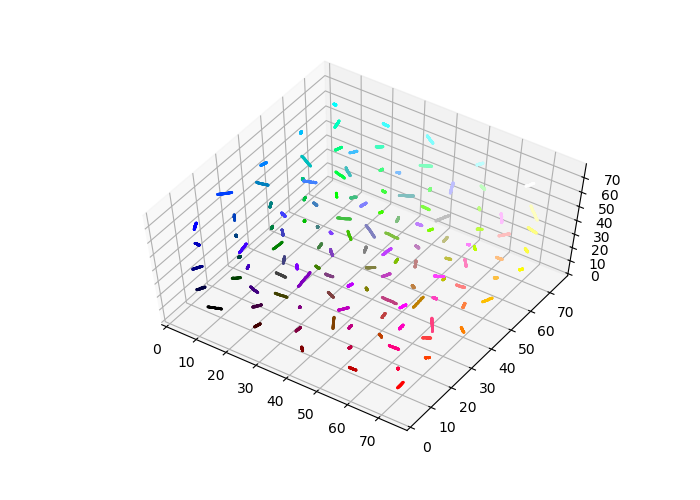

In [18]:
# Plotting individual atom as points

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

C = linspace(0, 255, 5)
C_list = array([list(x) for x in product(C, C, C)])/255

#ax.set_xlabel('Box x-axis')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for img in H2O_bulk_traj_pos:
    ax.scatter(img[:,0], img[:,1], img[:,2], c=C_list, s=1)
    
plt.show()

<IPython.core.display.Javascript object>


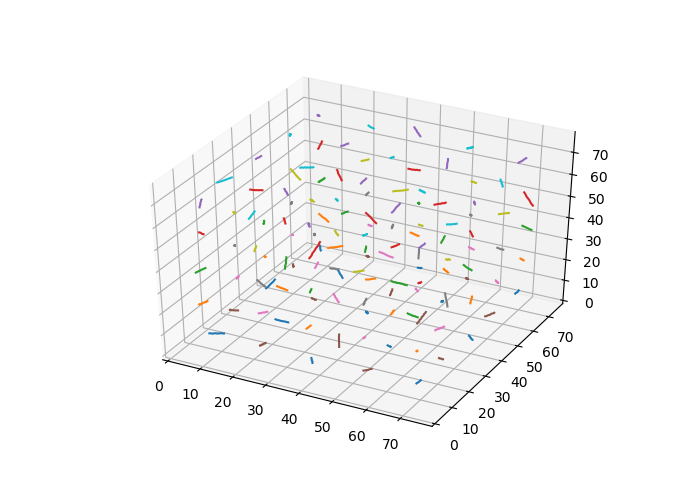

In [19]:
# Plotting individual atoms as lines. The lines crosses the whole simulation box when the particle
# crosses the PBs, not ideal.

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')

#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
ax.set_xlim(0, box_length*5)
ax.set_ylim(0, box_length*5)
ax.set_zlim(0, box_length*5)

for a in H2O_bulk_traj_pos_plot:
    ax.plot(a[0], a[1], a[2])

plt.show()

In [113]:
CO2_solvation = H2O_bulk_traj[-1].copy()

In [114]:
n_remove = randint(0,374)
i,j = neighbor_list('ij', H2O_last, 1.8, self_interaction=True)
index_remove = j[i == n_remove]

In [115]:
new_molecule = molecule('CO2')
new_molecule.set_positions(new_molecule.get_positions() + CO2_solvation[index_remove].get_positions()[0,:])

In [116]:
del CO2_solvation[index_remove]

In [117]:
CO2_solvation += new_molecule
CO2_solvation.pbc = True

In [119]:
view(CO2_solvation, viewer='ngl')

In [ ]:
# H2O configuration ref: http://www.wag.caltech.edu/home/duin/Reax/ReaxFF_HCO_JPCA.pdf
H2O_bulk_reaxff_params = {
    # Initialization
    "units": "real",
    "atom_style": "charge",
    "mass": ["1 12.011",
             "2 1.008",
             "3 15.999"],
    "velocity": ["all create 300.0 4928459 rot yes dist gaussian"],
    
    # Forcefield definition
    "pair_style": "reax/c NULL safezone 16",
    "pair_coeff": ['* * ' + 'ffield.reax.oh' + 'C H O'],
    "neighbor": "2.0 bin",
    #"neighbor_modify": "delay 10 check yes",
    
    # Run and Minimization
    "run": "1000",
    "timestep": 0.5,
    "fix": ["1 all nve",
            "2 all qeq/reax 1 0.0 10.0 1e-6 reax/c"]#,
            #"2 all temp/berendsen 300.0 300.0 100"]
}